In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

plt.style.use('seaborn-v0_8')

In [17]:
img_dir = '../data/images/'
hard_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

train_df = pd.read_csv('../data/datasets/train_reborn_02.csv')
train_df = train_df.reset_index(drop=True)

# oof_teacher1 = pd.read_csv('../data/datasets/oof_preds_Student5_EfficientNetB6_reborn.csv')
oof_df1 = pd.read_csv('../data/models/s10_convnext_small_T_scheduler/oof_preds_og_s10_convnext_small_T_scheduler.csv')
oof_df2 = pd.read_csv('../data/models/s12_conv_teacher_s10_v2/oof_preds_og_s12_conv_teacher_s10_v2.csv')
oof_student = pd.read_csv('../data/models/s14_resnest/oof_preds_og_s14_resnest.csv')

sub1 = pd.read_csv('../data/models/s12_conv_teacher_s10_v2/submission_og_s12_conv_teacher_s10_v2.csv')
sub2 = pd.read_csv('../data/models/s14_resnest/submission_og_s14_resnest.csv')

In [11]:
oof_df1['image_id'] = train_df['image_id']
oof_df1 = oof_df1[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]

oof_df = oof_df1.copy()
oof_df[hard_cols] = oof_df1[hard_cols] * 0.5 + oof_df2[hard_cols] * 0.5
oof_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0.007596,0.013527,0.004245,0.974609
1,Train_1,0.006436,0.911621,0.072968,0.008875
2,Train_2,0.974609,0.009743,0.007738,0.007946
3,Train_3,0.002924,0.005251,0.987549,0.004183
4,Train_4,0.975586,0.007423,0.011110,0.005968


Class healthy ECE: 0.1381
Class multiple_diseases ECE: 0.1451
Class rust ECE: 0.0769
Class scab ECE: 0.1312


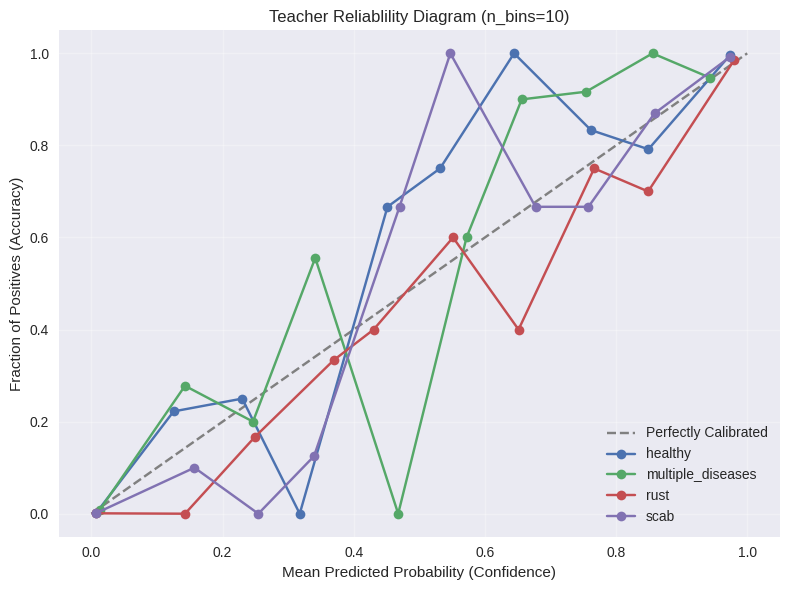

Class healthy ECE: 0.1202
Class multiple_diseases ECE: 0.0538
Class rust ECE: 0.1197
Class scab ECE: 0.1087


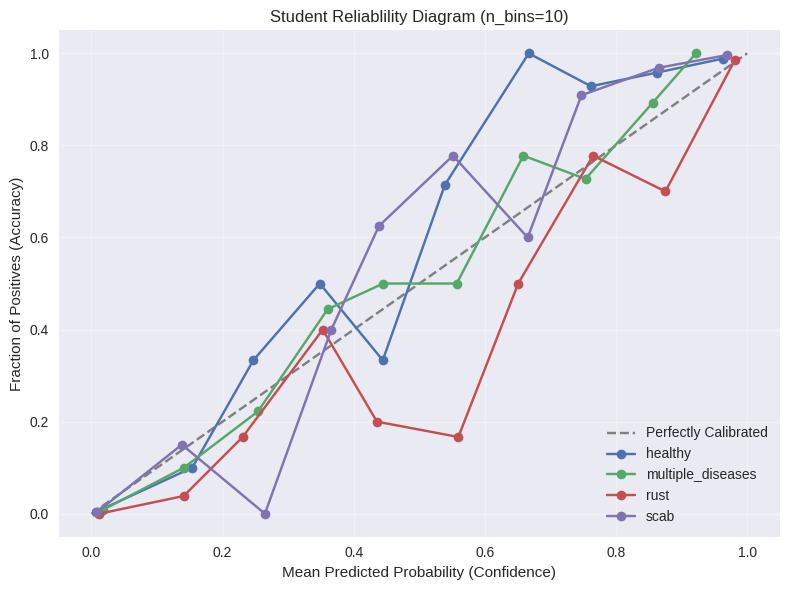

In [12]:
def plot_calibration_curve_multiclass(y_true, y_pred, class_names, n_bins=10, title="Reliability Diagram"):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 완벽한 보정선 (y=x)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    
    # 각 클래스별로 Calibration Curve 계산 및 시각화
    for i, label in enumerate(class_names):
        prob_true, prob_pred = calibration_curve(y_true[:, i], y_pred[:, i], n_bins=n_bins)
        ax.plot(prob_pred, prob_true, marker='o', label=f'{label}')
        ece = np.mean(np.abs(prob_pred - prob_true))
        print(f"Class {label} ECE: {ece:.4f}")

    ax.set_xlabel("Mean Predicted Probability (Confidence)")
    ax.set_ylabel("Fraction of Positives (Accuracy)")
    ax.set_title(f"{title} (n_bins={n_bins})")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


y_true_val = train_df[hard_cols].values
y_pred_teacher = oof_df[hard_cols].values
y_pred_student = oof_student[hard_cols].values

plot_calibration_curve_multiclass(y_true_val, y_pred_teacher, hard_cols, title='Teacher Reliablility Diagram')
plot_calibration_curve_multiclass(y_true_val, y_pred_student, hard_cols, title='Student Reliablility Diagram')

In [22]:
sub = sub1.copy()
sub[hard_cols] = sub1[hard_cols] * 0.1 + sub2[hard_cols] * 0.9
sub_file = '../data/ensemble_submission/submission_s12_ensemble_0109.csv'
sub.to_csv(sub_file, index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.002700,0.011233,0.983945,0.002133
1,Test_1,0.001577,0.011097,0.985020,0.002313
2,Test_2,0.008192,0.007635,0.005313,0.978916
3,Test_3,0.983281,0.004028,0.008136,0.004575
4,Test_4,0.002069,0.009566,0.985205,0.003192


In [21]:
os.environ['KAGGLE_CONFIG_DIR'] = "/teamspace/studios/this_studio/"
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f {sub_file} -m "s12 0.1 s14 0.9"

100%|█████████████████████████████████████████| 153k/153k [00:00<00:00, 428kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

In [ ]:
# sub1 = pd.read_csv('../data/submission_s5s8resnest.csv')
# sub2 = pd.read_csv('../data/models/Student9_convnext_small_inf_edited/submission_Student9_convnext_small_inf_edited.csv')
# sub3 = pd.read_csv('../data/models/Student9_convnext_small_droppath03/submission_Student9_convnext_small_droppath03.csv')
0.97320